In [13]:
# 必要なライブラリのインポート
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

try:
    if os.name == 'posix':
        japanese_fonts = ['Hiragino Sans', 'Hiragino Kaku Gothic Pro', 'Yu Gothic', 'Meiryo']
        for font in japanese_fonts:
            try:
                plt.rcParams['font.family'] = font
                break
            except:
                continue
except:
    pass

plt.rcParams['figure.figsize'] = (10, 6)
print("ライブラリのインポートが完了しました")

ライブラリのインポートが完了しました


In [14]:
def parse_directory_name(dir_name):
    params = dir_name.split(',')
    if len(params) < 30: return None, None, None
    try:
        cpnum = next((int(params[i]) for i in range(10) if int(params[i]) != 0), None)
        cpnum_range = next((int(params[i]) for i in range(10, 20) if int(params[i]) != 0), None)
        cpnum_dir = next((int(params[i]) for i in range(20, 30) if int(params[i]) != 0), None)
        return cpnum, cpnum_range, cpnum_dir
    except (ValueError, IndexError): return None, None, None

def collect_data(logs_root='../../Logs/'):
    data_records = []
    logs_path = Path(logs_root)
    for tree_dir in logs_path.glob('tree=*'):
        tree_value = int(tree_dir.name.split('=')[1])
        for param_dir in tree_dir.iterdir():
            if not param_dir.is_dir(): continue
            cpnum, cpnum_range, cpnum_dir = parse_directory_name(param_dir.name)
            if cpnum is None: continue
            bug_path = param_dir / 'detected_bugs.csv'
            if not bug_path.exists(): continue
            with open(bug_path, 'r') as f:
                for row in csv.reader(f):
                    data_records.append({
                        'tree': tree_value, 'cpNum': cpnum, 
                        'cpNum_range': cpnum_range, 'cpNum_dir': cpnum_dir,
                        'bug_detected': 0 if row[0] in ['timeout', 'null'] else 1
                    })
    df = pd.DataFrame(data_records)
    print(f"データ収集完了: {len(df)}件")
    return df

df = collect_data()

データ収集完了: 10800件


# タスク0: バグ発見の有無（二値分類）ランダムフォレスト

In [15]:
X = df[['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']]
y = df['bug_detected']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print(f"訓練データ: {len(X_train)}, テストデータ: {len(X_test)}")

訓練データ: 8640, テストデータ: 2160


## GridSearchCVによるランダムフォレストの探索

In [16]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid_rf = {
    'rf__n_estimators': [10, 20, 30, 50, 100, 300],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_leaf': [1, 5, 0.01, 0.05],
    'rf__max_features': ['sqrt', 'log2', None]
}

grid_search_rf = GridSearchCV(
    pipeline_rf, 
    param_grid_rf, 
    cv=cv, 
    scoring='f1', 
    n_jobs=-1, 
    verbose=1
)

print("探索を開始します...")
grid_search_rf.fit(X_train, y_train)

print(f"\nBest Parameters: {grid_search_rf.best_params_}")
print(f"Best CV F1-Score: {grid_search_rf.best_score_:.4f}")

探索を開始します...
Fitting 10 folds for each of 216 candidates, totalling 2160 fits

Best Parameters: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 0.01, 'rf__n_estimators': 10}
Best CV F1-Score: 0.8651


## 最良モデルの評価と重要度分析

【テストデータでの評価】
Accuracy:  0.8375
Precision: 0.8807
Recall:    0.8305
F1-Score:  0.8549

【混同行列】
[[ 775  140]
 [ 211 1034]]

【特徴量重要度】
cpNum_range    0.740546
cpNum          0.253831
tree           0.005362
cpNum_dir      0.000261
dtype: float64


/var/folders/ys/vftz7rxd7x3bwtxbwg0llgpc0000gn/T/ipykernel_67064/608240709.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


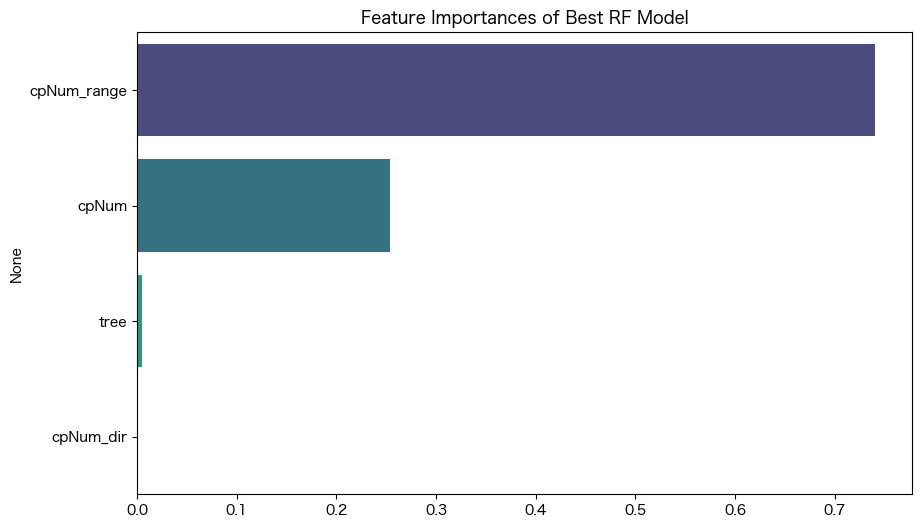

In [17]:
best_model_rf = grid_search_rf.best_estimator_
y_pred = best_model_rf.predict(X_test)

print("【テストデータでの評価】")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred):.4f}")

print("\n【混同行列】")
print(confusion_matrix(y_test, y_pred))

print("\n【特徴量重要度】")
rf_inner = best_model_rf.named_steps['rf']
importances = pd.Series(rf_inner.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title('Feature Importances of Best RF Model')
plt.show()

## 探索結果の可視化

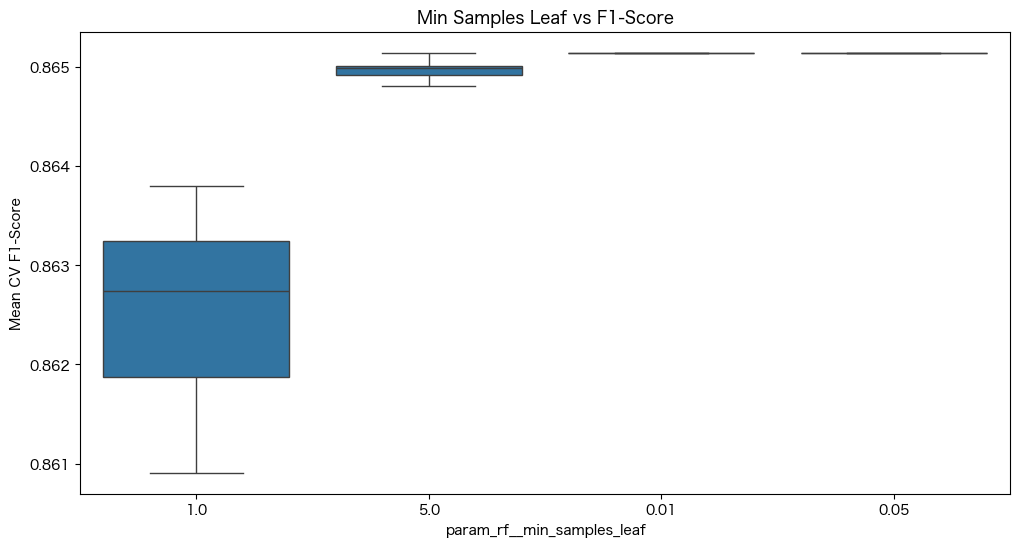

In [18]:
results_df = pd.DataFrame(grid_search_rf.cv_results_)
results_df['param_rf__min_samples_leaf'] = results_df['param_rf__min_samples_leaf'].astype(str)

plt.figure(figsize=(12, 6))
sns.boxplot(x='param_rf__min_samples_leaf', y='mean_test_score', data=results_df)
plt.title('Min Samples Leaf vs F1-Score')
plt.ylabel('Mean CV F1-Score')
plt.show()